## EIAW test

In [1]:
from EIAW import EIAW
import kornia.losses
import lpips as lpips
import torchvision.models as models
import torch
import matplotlib.pyplot as plt
from PIL import Image
from utils import *
from torch import nn
import numpy as np
import torch_dct as dct
import label_list as ll

import time
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
lpips_criterion = lpips.LPIPS().to(device) 

class Classifier_model(nn.Module):
    def __init__(self, model):
        super(Classifier_model, self).__init__()  
        self.model = model

    def forward(self, image):
        image = normalize(image)
        output = self.model(image)
        return output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


backbone_name = "resnet101"
model = models.__dict__[backbone_name](pretrained=True) 
model = model.to(device)

Classifier = Classifier_model(model)
Classifier.eval() 
print("--")

attack_type = "EIAW"
attack = EIAW(Classifier,device, steps=20, use_monitor= True)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


d:\anaconda\envs\Jade\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda\envs\Jade\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: d:\anaconda\envs\Jade\lib\site-packages\lpips\weights\v0.1\alex.pth


d:\anaconda\envs\Jade\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


--


### attack one image

**********
success iter:  0
original label:  cradle
wrong label:  crib
attack success!
psnr:  48.486915588378906
ssim:  0.9927302356809378
lpips:  0.001238073455169797
extract success:  0.9997694492340088


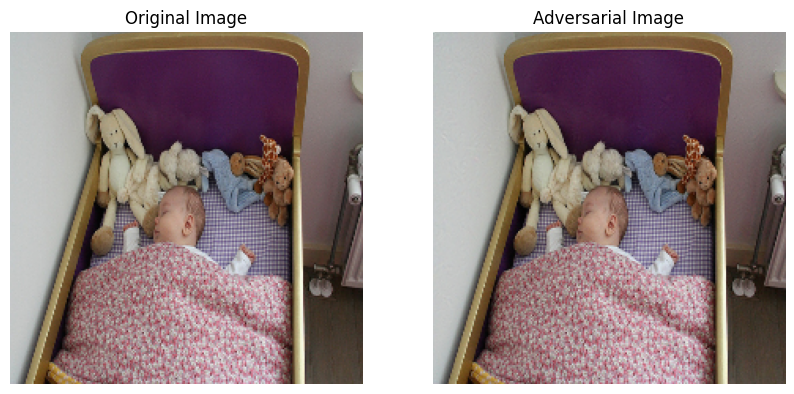

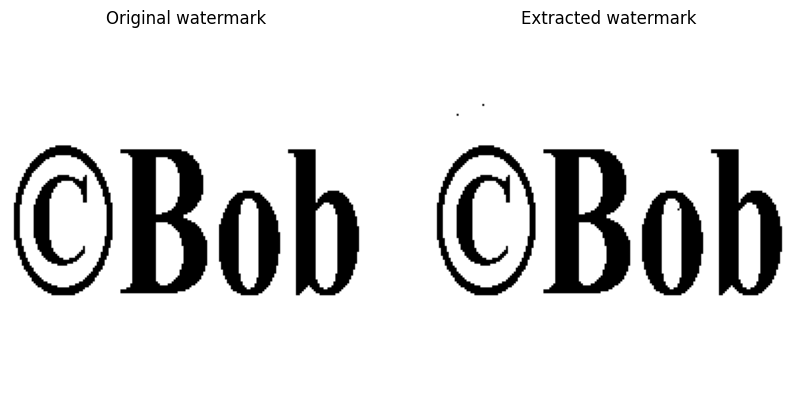

In [2]:
p = 2
ratio = 0.8

h, w = (224,224)
start_ratio = 0.0

start_pos = int(start_ratio * h)

mask = torch.zeros((1,3,h,w)).to(device)
mask[:, :, start_pos : start_pos + int(h * 1 * ratio), start_pos : start_pos + int(h * 1 * ratio)] = 1

watermark_path = "watermarks\Bob.png"

target_size = (224,224)
watermark = preprocess_watermark_mask(watermark_path, target_size, ratio, start_ratio).to(device)


i = 4
image_path='./imagenet/'+str(i)+'.png'

if os.path.exists(image_path):
    image = Image.open(image_path)
    image = transforms.ToTensor()(image).unsqueeze(0)

    image = image.to(device)

    predict = Classifier(image)
    label = torch.tensor([torch.argmax(predict[0])]).to(device)
    
    if 1:
        print('**********')

        adv_image = attack(image, label, watermark, mask, p )

        ex_watermark = extract_watermark(adv_image,p,mask)

        output_adv = Classifier(adv_image)
        output_label = torch.tensor([torch.argmax(output_adv[0])]).to(device)
        
        in_label=ll.label_find(label[0].item())
        out_label=ll.label_find(output_label[0].item())

        print("original label: ",in_label)
        print("wrong label: ",out_label)

        if output_label!=label:
            print("attack success!")
            
            psnr = -kornia.losses.psnr_loss(image, adv_image, 1.0).item()
            ex_watermark = ex_watermark[start_pos : start_pos + int(h * 1 * ratio), start_pos : start_pos + int(h * 1 * ratio)]
            watermark = watermark[start_pos : start_pos + int(h * 1 * ratio), start_pos : start_pos + int(h * 1 * ratio)]

            
            ssim = 1 - 2 * kornia.losses.ssim_loss(image, adv_image, window_size=5, reduction="mean").item()
            lpips = torch.mean(lpips_criterion(adv_image.to(device),image.to(device))).item()
            NC = compute_NC(watermark, ex_watermark)
            print("psnr: ",psnr)
            print("ssim: ",ssim)
            print("lpips: ",lpips)
            print("extract success: ",NC)

            tensor_to_pil = transforms.ToPILImage()
        
            ori_img = tensor_to_pil(image.squeeze(0))
            adv_img = tensor_to_pil(adv_image.squeeze(0))  

            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
   
            axes[0].imshow(ori_img)
            axes[0].set_title('Original Image')
            axes[0].axis('off')
            axes[1].imshow(adv_img)
            axes[1].set_title('Adversarial Image')
            axes[1].axis('off') 
            plt.show()

            fig, axes = plt.subplots(1, 2, figsize=(10, 5))

            axes[0].imshow(watermark.cpu().numpy(), cmap='gray')  
            axes[0].set_title('Original watermark')
            axes[0].axis('off')

            axes[1].imshow(ex_watermark.cpu().numpy(), cmap='gray') 
            axes[1].set_title('Extracted watermark')
            axes[1].axis('off')


            plt.show()


### test on 1000 images

In [3]:
backbone_name = "resnet101"
model = models.__dict__[backbone_name](pretrained=True) # N x 2048
model = model.to(device)

Classifier = Classifier_model(model)
Classifier.eval()  

attack_type = "EIAW"

max_iter = 30
attack = EIAW(Classifier,device, steps=max_iter, use_monitor= True)

import logging

seed_torch(42) # it doesnot work if the mode of F.interpolate is "bilinear"
logging.basicConfig(filename='./logs/attack_results.log', level=logging.INFO, format='%(asctime)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

p = 2
ratio = 0.5
h, w = (224,224)
start_ratio = 0.0
start_pos = int(start_ratio * h)

mask = torch.zeros((1,3,h,w)).to(device)
mask[:, :, start_pos : start_pos + int(h * 1 * ratio), start_pos : start_pos + int(h * 1 * ratio)] = 1
watermark = torch.randint(2, size=(h, w), dtype=torch.float32).to(device)

count = 0
count1 = 0
watermark_ex = 0
avg_psnr = 0
avg_ssim = 0
avg_lpips = 0
total_time = 0


for i in range(1000):
    path='./imagenet/'+str(i)+'.png'
    if os.path.exists(path):
        image = Image.open(path)
        image = transforms.ToTensor()(image).unsqueeze(0)
    else:
        continue

    image = image.to(device)
    label = torch.tensor([int(classes[i])]).to(device)
    predict = Classifier(image)

    if torch.argmax(predict[0])==int(classes[i]):
        print('**********')
        print(i)
        count = count + 1

        start_time = time.time()  
        
        adv_image = attack(image, label,watermark, mask, p )

        end_time = time.time()  
        
        ex_watermark = extract_watermark(adv_image,p,mask)
        ex_success = (watermark.cpu().numpy() == ex_watermark.cpu().numpy())[mask[0,0,:,:].bool().cpu()].mean()
        
        output_adv = Classifier(adv_image)

        if torch.argmax(output_adv[0])!=label[0]:
            print("attack success!")
            count1 = count1 + 1
            watermark_ex += ex_success
            
            psnr = -kornia.losses.psnr_loss(image, adv_image, 1.0).item()
            ssim = 1 - 2 * kornia.losses.ssim_loss(image, adv_image, window_size=5, reduction="mean").item()
            lpips = torch.mean(lpips_criterion(adv_image.to(device),image.to(device))).item()

            print("extract success rate: ",ex_success)
            print("psnr: ",psnr)
            print("ssim: ",ssim)
            print("lpips: ",lpips)
            avg_psnr += psnr
            avg_ssim += ssim
            avg_lpips += lpips


            attack_time = end_time - start_time 
            total_time += attack_time 
            print("Time taken: ", attack_time)

            tensor_to_pil = transforms.ToPILImage()
        
            ori_image = tensor_to_pil(image.squeeze(0))
            adv_image = tensor_to_pil(adv_image.squeeze(0))   

print("attack_type: ",attack_type)
print("attack_model: ",backbone_name)
print('attack_success_rate: ',count1/count)
print('extract_success_rate:', watermark_ex/count1)  
print('psnr: ', avg_psnr / count1)  
print('ssim: ', avg_ssim / count1)  
print('lpips: ', avg_lpips / count1)  
print('average_attack_time:', total_time / count1)

# log
logging.info("-----------------------------------------------")
logging.info("attack_type: %s",attack_type)
logging.info("ratio: %f",ratio)
logging.info("start_ratio: %f",start_ratio)
logging.info("max_iter: %s",max_iter)
logging.info("attack_model: %s",backbone_name)
logging.info('attack_success_rate: %f', count1/count)
logging.info('extract_success_rate: %f', watermark_ex/count1)  
logging.info('psnr: %f', avg_psnr / count1)  
logging.info('ssim: %f', avg_ssim / count1)  
logging.info('lpips: %f', avg_lpips / count1)  
logging.info('average_attack_time: %f', total_time / count1)

**********
0
success iter:  0
attack success!
extract success rate:  1.0
psnr:  52.528629302978516
ssim:  0.9978903101291507
lpips:  0.0005173403769731522
Time taken:  0.17799687385559082
**********
2
success iter:  0
attack success!
extract success rate:  1.0
psnr:  52.539154052734375
ssim:  0.9985605319961905
lpips:  0.0004725743201561272
Time taken:  0.0480196475982666
**********
3
success iter:  0
attack success!
extract success rate:  1.0
psnr:  52.518192291259766
ssim:  0.9970019988249987
lpips:  0.0004821626062039286
Time taken:  0.04400038719177246
**********
4
success iter:  0
attack success!
extract success rate:  0.9999202806122449
psnr:  52.60036087036133
ssim:  0.9974986694287509
lpips:  0.0003774552315007895
Time taken:  0.05300092697143555
**********
6
success iter:  1
attack success!
extract success rate:  1.0
psnr:  49.12046432495117
ssim:  0.99716886295937
lpips:  0.0010469473199918866
Time taken:  0.095001220703125
**********
8
success iter:  0
attack success!
extrac

KeyboardInterrupt: 